In [1]:
# !pip install -U pip
# !pip install -U scikit-image
# !pip install -U ipympl
# For easier dev of local modules:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import os, sys

# Initialize my ml_toolkit which is cloned to this instance
path = os.path.abspath(os.path.join(os.path.dirname('../../..')))
print(path)
sys.path.append(path)
from ml_toolkit.ml_toolkit import MLToolkit
from ml_toolkit.visualization import Visualization
toolkit = MLToolkit()
#visualization = Visualization()

/home/ec2-user/SageMaker


## Computer Vision I Final Project

In this walkthrough, we will look at reading training, test data and creating a submission file for your final project. Once you train your model and get your predictions, submit your model's .csv output to the class [Leaderboard](https://leaderboard.corp.amazon.com/tasks/312)

## Set up SageMaker

Are your models taking too long to train? Use a P2 instance as described in the README.

## Data Access

In this part, we will see how to read training and test data

## 1. Training data

In [3]:
#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd

df = pd.read_pickle("/tmp/training_data.pkl")
df.head()

,ID,data,label
0,1588,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
1,2011,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,1321,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,669,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,1674,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1


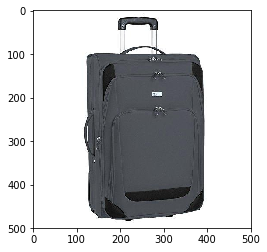

In [4]:
#Let's see what kind of data we're working with
import matplotlib.pyplot as plt

plt.imshow(df['data'][90])

Our labels correspondend to the following:

* Class 0: *Inconclusive*
* Class 1: *Two wheels*
* Class 2: *Four wheels*
* Class 3: *Not luggage*
* Class 4: *Zero wheels*

In [5]:
# Let's take a look at this data in more detail and then start working. Remember 'label' is our target variable/column
df.loc[90]

ID                                                    1221
data     [[[255, 255, 255], [255, 255, 255], [255, 255,...
label                                                    1
Name: 90, dtype: object

## Split the data into Training 90% and Validation 10%

In [6]:
import numpy as np
from skimage.transform import resize
from mxnet import gluon

train_percentage = 0.9

# shuffling the dataframe
#df = df.sample(frac=1)


# # Splitting into training and validation subset
train_indices = np.arange(0, int(train_percentage*len(df)))
val_indices = np.arange(int(train_percentage*len(df)), len(df))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]

# del df

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    extra_images = []
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im
    return (image_arr)

train_images, train_labels = getImages(train_df['data'].values), train_df['label'].values
validation_images, validation_labels = getImages(val_df['data'].values), val_df['label'].values

print('no. of train images: {}'.format(len(train_images)))
print('no. of validation images: {}'.format(len(validation_images)))

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)





no. of train images: 1616
no. of validation images: 180


In [7]:
org_train_images = np.array(train_images, copy=True)
org_train_labels = np.array(train_labels, copy=True)

In [8]:
train_images = np.array(org_train_images, copy=True)
train_labels = np.array(org_train_labels, copy=True)
print('no. of train images: {}'.format(len(train_images)))
print('no. of train labels: {}'.format(len(train_labels)))
print('no. of validation images: {}'.format(len(validation_images)))

no. of train images: 1616
no. of train labels: 1616
no. of validation images: 180


In [9]:

flipped_images = []
flipped_labels = []
for idx, label in enumerate(train_labels):
    if label in [0, 3]:
        flipped_images.append(np.fliplr(train_images[idx]))
        flipped_labels.append(label)
#         flipped_images.append(np.flipud(train_images[idx]))
#         flipped_labels.append(label)
#         flipped_images.append(np.flip(train_images[idx], (0, 1)))
#         flipped_labels.append(label)
print(len(flipped_images))
print(len(flipped_labels))
train_images = np.concatenate((train_images, flipped_images))
train_labels = np.concatenate((train_labels, flipped_labels))
print('no. of train images: {}'.format(len(train_images)))
print('no. of train labels: {}'.format(len(train_labels)))
print('no. of validation images: {}'.format(len(validation_images)))



114
114
no. of train images: 1730
no. of train labels: 1730
no. of validation images: 180


In [10]:
# Weighting
no_samples_per_label = np.zeros(5, dtype="int")
for label in train_labels:
    no_samples_per_label[label] = no_samples_per_label[label]+1
print(no_samples_per_label)
weights = np.zeros(5, dtype="float32")
for i, n in enumerate(no_samples_per_label):
    weights[i] = (1-(n/len(train_images)))/4
print(weights)

[156 657 500  72 345]
[0.22745664 0.1550578  0.17774567 0.23959537 0.20014451]


In [11]:
# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

## Plot the class distribution

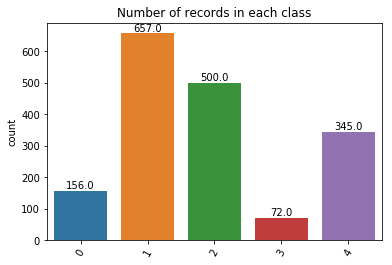

In [12]:
toolkit.draw_class_distribution(train_labels)

## Confusion Matrix

## Training and Validation

In [13]:

from ml_toolkit.ml_toolkit import MLToolkit
toolkit = MLToolkit()

In [14]:
import mxnet as mx
from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

epochs = 10


def train(weights):
    # Set this to CPU or GPU depending on your training instance
    # ctx = mx.cpu()
    ctx = mx.gpu()

    # Hyper-paramaters of the system
    batch_size = 64
    #epochs = 150
    learning_rate = 0.01

    # Weighing
    #weights = nd.array([0.23,0.15,0.18,0.24,0.20])
    weights = nd.array(weights)

    # Create the network. We have 5 classes
    num_outputs = 5

    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Conv2D(channels=60, kernel_size=3, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        # The Flatten layer collapses all axis, except the first one, into one axis.
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(512, activation="relu"))
        net.add(gluon.nn.Dense(num_outputs))

    # Initialize parameters
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

    # Define loss and trainer.
    softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

    train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Starting the outer loop, we will have 3 epochs (3 full pass through our dataset)
    for epoch in range(epochs):

        # Training loop: (with autograd and trainer steps, etc.)
        # This loop does the training of the neural network (weights are updated)
        cumulative_train_loss = 0
        train_predictions = []
        for i, (data, label) in enumerate(train_loader):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            w = weights.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
                loss = softmax_cross_etropy_loss(output, label, w)
                cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
            loss.backward()
            trainer.step(data.shape[0])

        # Calculating the Softmax Cross Entopy Loss for training
        train_loss = cumulative_train_loss/len(train_images)

        # Validation loop:
        # This loop tests the trained network on validation dataset
        # No weight updates here
        cumulative_valid_loss = 0
        val_predictions = []
        for i, (data, label) in enumerate(validation_loader):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            w = weights.as_in_context(ctx)
            output = net(data)
            val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            val_loss = softmax_cross_etropy_loss(output, label, w)
            cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
        valid_loss = cumulative_valid_loss/len(validation_images)

        # Calculate training and validation accuracies
        # I used a accuracy_score() function from the sklearn library here. 
        # accuracy = (TP+TN) / (TP+FP+TN+FN)
        train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
        validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)

        # Print the summary and plot the confusion matrix after each epoch
    #     print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    #     if epoch % 5 == 0 and epoch != 0:
    #         plot_confusion_matrix(validation_labels.tolist(), val_predictions)
        text_string = "Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy)
        #toolkit.plot_confusion_matrix(text_string, validation_labels.tolist(), val_predictions)
        toolkit.set_confusion_matrix(epoch, text_string, validation_labels.tolist(), val_predictions)
        toolkit.write_epochs(text_string)

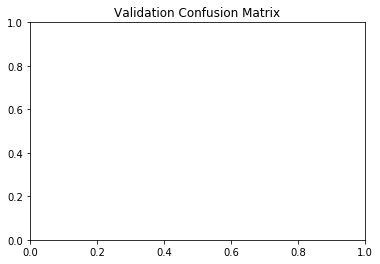

In [15]:
toolkit.prepare_training_widget(no_of_epochs=epochs)
toolkit.display_training_widget()

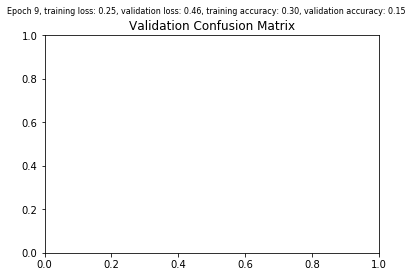

In [16]:
train(weights)

## 2. Test Data

In [ ]:
# If you're unsure of how to submit to Leaderboard, no problemo.You'll use the training file loaded above to make your ML model and then predict on the files below:

test_df = pd.read_pickle("/tmp/test_data.pkl")
plt.imshow(test_df['data'][90])

In [ ]:
test_df.head()

## Sample zero submission file

In [ ]:
# Below is an example submission of a very poor model

test_submission = pd.read_csv('/tmp/sample_model_output.csv', header=0)
test_submission.head(5)

In [ ]:
test_images = getImages(test_df["data"].values)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)

test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

## Your submission file

In [ ]:
import pandas as pd
import os

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
# Get your model's predictions when submitting (not the zero submission here)
result_df["label"] = test_predictions #test_submission['label'].values

result_df.to_csv("results_cv_project.csv", index=False)

If you navigate to the day1/results folder in the Jupyter file browser, you can select the results_cv_project.csv and dowload it locally. Or just click this [link...](./results_cv_project.csv)

## Getting our model output into Leaderboard

We now have our model's output .csv and are ready to upload to Leaderboard
1. Go to your class [Leaderboard instance](https://leaderboard.corp.amazon.com/tasks/312) and go to the 'Make a Submission' section
2. Upload your local file and include your notebook version URL for tracking
3. Your score on the public leaderboard should now appear. Marvel on how much room for improvement there is